In [0]:
#@title Summarizer { display-mode: "form" }

In [2]:
!git clone https://github.com/thushv89/attention_keras.git

Cloning into 'attention_keras'...
remote: Enumerating objects: 17, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 119 (delta 7), reused 0 (delta 0), pack-reused 102
Receiving objects: 100% (119/119), 193.62 KiB | 549.00 KiB/s, done.
Resolving deltas: 100% (56/56), done.


In [3]:
from google.colab import drive

drive.mount('/content/gdrive') 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
from attention_keras.layers import attention

In [5]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords

from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
import re

Using TensorFlow backend.


In [6]:
import nltk
nltk.download('stopwords')
stopWords = set(stopwords.words('english'))
print(stopWords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
{'all', 'here', 'it', 'an', 'just', 'haven', 'why', 'at', 'over', "won't", 'from', 'won', 'out', 'these', 'he', 'yourselves', 'ourselves', 'i', 'some', "you've", 'but', 'is', "isn't", 'myself', 's', 'ain', 'that', 'm', "weren't", 'did', 'again', "aren't", "doesn't", 'against', 'during', 'nor', 'my', "didn't", 'isn', "couldn't", 'your', 'yours', "mightn't", 'into', 'if', 'when', 'aren', 'hers', 'above', 'through', 'didn', 'both', 'with', 'themselves', 'while', 'or', 'few', "you'd", "wasn't", 'such', 'once', 'what', 'of', 'between', 'how', 'couldn', 'shan', 'in', "needn't", 'their', 'having', 'being', 'yourself', 'who', 'o', 'very', "mustn't", 'weren', 'hasn', 'we', 'further', 'y', 'd', 'ma', "hasn't", 'and', 'don', "you'll", 'by', 'there', 'its', "wouldn't", 'have', 'this', 'those', "shouldn't", 'wasn', 'can', 'should', 'me', 'before', 're', 'does', 'on', 'own', 'mightn', 'then

In [0]:
data = pd.read_csv('/content/gdrive/My Drive/amazon_food_reviews/Reviews.csv',nrows=100000)

In [70]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 10 columns):
Id                        100000 non-null int64
ProductId                 100000 non-null object
UserId                    100000 non-null object
ProfileName               99996 non-null object
HelpfulnessNumerator      100000 non-null int64
HelpfulnessDenominator    100000 non-null int64
Score                     100000 non-null int64
Time                      100000 non-null int64
Summary                   99998 non-null object
Text                      100000 non-null object
dtypes: int64(5), object(5)
memory usage: 7.6+ MB


In [71]:
pd.set_option("display.max_colwidth", 200)
data[pd.notnull(data["Summary"])].head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo""."
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all","This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with ..."
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient in Robitussin I believe I have found it. I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda. The fl...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,"Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very quick. If your a taffy lover, this is a deal."


In [0]:
dup = data[data.duplicated(['Text'])]

In [0]:
data.drop_duplicates(subset=['Text'],keep='first',inplace=True)
data.dropna(axis=0,inplace=True)

In [74]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88421 entries, 0 to 99999
Data columns (total 10 columns):
Id                        88421 non-null int64
ProductId                 88421 non-null object
UserId                    88421 non-null object
ProfileName               88421 non-null object
HelpfulnessNumerator      88421 non-null int64
HelpfulnessDenominator    88421 non-null int64
Score                     88421 non-null int64
Time                      88421 non-null int64
Summary                   88421 non-null object
Text                      88421 non-null object
dtypes: int64(5), object(5)
memory usage: 7.4+ MB


In [0]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

In [0]:
'''stop_words = set(stopwords.words('english')) 
def text_cleaner(text):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    tokens = [w for w in newString.split() if not w in stop_words]
    long_words=[]
    for i in tokens:
        if len(i)>=3:                  #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

cleaned_text = []
for t in data['Text']:
    cleaned_text.append(text_cleaner(t))'''

In [0]:
'''def summary_cleaner(text):
    newString = re.sub('"','', text)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    newString = newString.lower()
    tokens=newString.split()
    newString=''
    for i in tokens:
        if len(i)>1:                                 
            newString=newString+i+' '  
    return newString

#Call the above function
cleaned_summary = []
for t in data['Summary']:
    cleaned_summary.append(summary_cleaner(t))

data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary
data['cleaned_summary'].replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)'''

In [0]:
stop_words = set(stopwords.words('english')) 

def text_cleaner(text,num):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    newString = re.sub('[m]{2,}', 'mm', newString)
    if(num==0):
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens=newString.split()
    long_words=[]
    for i in tokens:
        if len(i)>1:                                                 #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

In [0]:
cleaned_text = []
for t in data['Text']:
    cleaned_text.append(text_cleaner(t,0))

In [78]:
cleaned_summary = []
for t in data['Summary']:
    cleaned_summary.append(text_cleaner(t,1))

/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:336: UserWarning: "http://www.amazon.com/gp/product/b007i7yygy/ref=cm_cr_rev_prod_title" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


In [0]:
data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary
data['cleaned_summary'].replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

In [80]:
data['cleaned_summary']

0                                                        good quality dog food
1                                                            not as advertised
2                                                          delight says it all
3                                                               cough medicine
4                                                                  great taffy
                                         ...                                  
99995                                                                    yummy
99996                                                         tastes like more
99997                                                              great ramen
99998                                                                    spicy
99999    this spicy noodle cures my cold upset stomach and headache every time
Name: cleaned_summary, Length: 88351, dtype: object

In [0]:
#data['cleaned_summary'] = data['cleaned_summary'].apply(lambda x : '_START_ '+ x + ' _END_')

Distribution analysis

In [82]:
import matplotlib.pyplot as plt
text_count = []
summary_count = []

data['cleaned_text'].apply(lambda x: text_count.append(len(x.split())))
data['cleaned_summary'].apply(lambda x: summary_count.append(len(x.split())))

0        None
1        None
2        None
3        None
4        None
         ... 
99995    None
99996    None
99997    None
99998    None
99999    None
Name: cleaned_summary, Length: 88351, dtype: object

In [0]:
data = data.drop(columns=['Text','Summary'])

In [84]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,cleaned_text,cleaned_summary
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better,good quality dog food
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo,not as advertised
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat famil...,delight says it all
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal,cough medicine
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,great taffy great price wide assortment yummy taffy delivery quick taffy lover deal,great taffy


In [85]:
print(len(text_count))
print(text_count[55])

88351
18


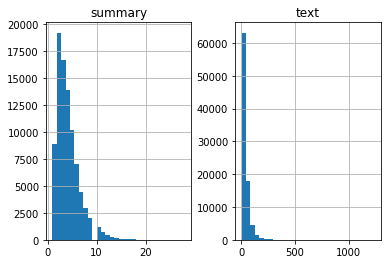

In [86]:
length_df = pd.DataFrame({'text':text_count, 'summary':summary_count})
length_df.hist(bins = 30)
plt.show()

In [87]:
count = 0

for i in data['cleaned_summary']:
  if(len(i.split()) < 9):
    count = count+1
percen = count/len(data['cleaned_summary'])

print(percen)

0.9424907471335922


In [0]:
max_len_text=80 
max_len_summary=10

In [89]:
length_df.text.describe()

count    88351.000000
mean        38.792962
std         36.660462
min          2.000000
25%         17.000000
50%         28.000000
75%         47.000000
max       1235.000000
Name: text, dtype: float64

In [0]:
data['cleaned_summary'] = data['cleaned_summary'].apply(lambda x : 'sostok '+ x + ' eostok')

In [91]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88351 entries, 0 to 99999
Data columns (total 10 columns):
Id                        88351 non-null int64
ProductId                 88351 non-null object
UserId                    88351 non-null object
ProfileName               88351 non-null object
HelpfulnessNumerator      88351 non-null int64
HelpfulnessDenominator    88351 non-null int64
Score                     88351 non-null int64
Time                      88351 non-null int64
cleaned_text              88351 non-null object
cleaned_summary           88351 non-null object
dtypes: int64(5), object(5)
memory usage: 7.4+ MB


In [0]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val = train_test_split(np.array(data['cleaned_text']),np.array(data['cleaned_summary']),test_size=0.1,random_state=0,shuffle=True)

In [93]:
y_val.shape

(8836,)

In [94]:
x_tr

array(['found great little cookies looking anything low salt cookies cakes pastry line admit eating one exactly ecstatic experience eating really top quality brownie good thing decided delicious seem bulldoze willpower way super sweet buttery rich treat crispy similar hard biscotti still easy pleasant munch thin bite easily low salt also quite low calories like little something sweet coffee mornings couple cookies gets done remarkable calories never felt satisfied accompaniment coffee anywhere near number calories let us crazy substitute egg mcmuffin kind traditional breakfast essentially light tea biscuit goes awfully long way love edit placed order packs eighty bucks worth cookies less became much burden repeatedly order someone complained broken problem break bought broken grocery store realistically much problem unless serving elegant tea problem lot bite sized bits amazon price little higher sure happening price grocery store mostly order hunt grocery store bit category buster har

In [0]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr,  maxlen=max_len_text, padding='post') 
x_val   =   pad_sequences(x_val, maxlen=max_len_text, padding='post')

x_voc_size   =  len(x_tokenizer.word_index) +1

In [0]:
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

#convert summary sequences into integer sequences
y_tr    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr, maxlen=max_len_summary, padding='post')
y_val   =   pad_sequences(y_val, maxlen=max_len_summary, padding='post')

y_voc_size  =   len(y_tokenizer.word_index) +1

In [97]:
y_val.shape

(8836, 10)

In [98]:
y_tokenizer.word_counts['sostok'],len(y_tr)

(79515, 79515)

In [99]:
y_tokenizer.word_index['eostok']

2

In [100]:
y_tokenizer.word_index['sostok']

1

In [0]:
ind = []
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [0]:
ind = []
for i in range(len(y_val)):
  cnt = 0
  for j in y_val[i]:
    if j!=0:
      cnt = cnt+1
  if (cnt==2):
      ind.append(i)

y_val = np.delete(y_val,ind,axis=0)
x_val = np.delete(x_val,ind,axis=0)

In [103]:
x_tr.shape

(79515, 80)

In [105]:
y_val.shape

(8768, 10)

In [104]:
y_voc_size

14018

Model Initialization

In [0]:
from keras import backend as K 
K.clear_session() 
latent_dim = 500 

# Encoder 
encoder_inputs = Input(shape=(max_len_text,)) 
enc_emb = Embedding(x_voc_size, latent_dim,trainable=True)(encoder_inputs) 

encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 

encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 
 
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True) 
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2) 

# decoder. 
decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(y_voc_size, latent_dim,trainable=True) 
dec_emb = dec_emb_layer(decoder_inputs) 

#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 

#Attention Layer
attn_layer = attention.AttentionLayer(name='attention_layer') 
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs]) 

# Concat attention output and decoder LSTM output 
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#Dense layer
decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 

In [107]:
model = Model([encoder_inputs,decoder_inputs],decoder_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 80, 500)      26078000    input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 80, 500), (N 2002000     embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [0]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

In [0]:
es = EarlyStopping(monitor='val_loss', mode='min')

In [110]:
len(y_val[:-1])

8767

In [111]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,
                  epochs=50,callbacks=[es],batch_size=128,
                  validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Train on 79515 samples, validate on 8768 samples
Epoch 1/50
79515/79515 [==============================] - 332s 4ms/sample - loss: 2.9643 - val_loss: 2.5347
Epoch 2/50
79515/79515 [==============================] - 326s 4ms/sample - loss: 2.4842 - val_loss: 2.3467
Epoch 3/50
79515/79515 [==============================] - 331s 4ms/sample - loss: 2.2761 - val_loss: 2.2655
Epoch 4/50
79515/79515 [==============================] - 349s 4ms/sample - loss: 2.1078 - val_loss: 2.2171
Epoch 5/50
79515/79515 [==============================] - 352s 4ms/sample - loss: 1.9647 - val_loss: 2.1927
Epoch 6/50
79515/79515 [==============================] - 350s 4ms/sample - loss: 1.8262 - val_loss: 2.1770
Epoch 7/50
79515/79515 [==============================] - 332s 4ms/sample - loss: 1.6921 - val_loss: 2.1901


In [0]:
#history=model.fit([x_tr,y_tr], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1),epochs=50,callbacks=[es],batch_size=128, validation_data=([x_val,y_val], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)))

In [0]:
model.save("/content/gdrive/My Drive/summarizer.h5")

In [0]:
y_val[0,1:]

In [0]:
model.save_weights("/content/gdrive/My Drive/sum_weights.h5")

In [0]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],label='training_loss')
plt.plot(history.history['val_loss'],label='vali_loss')
plt.legend()
plt.show()

In [0]:
reverse_target_word_index=y_tokenizer.index_word 
reverse_source_word_index=x_tokenizer.index_word 
target_word_index=y_tokenizer.word_index

In [0]:
#reverse_target_word_index[0] = 'end'
#reverse_source_word_index[0] = 'end'

In [0]:
x_tokenizer.word_index['scd']

Inference

In [0]:
#encoder
encoder_model = Model(encoder_inputs,[encoder_outputs,state_h,state_c])

#decoder
decoder_state_input_h = Input(shape = (latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))

dec_emb2 = dec_emb_layer(decoder_inputs)
decoder_outputs2,state_h2,state_c2 = decoder_lstm(dec_emb2,initial_state=[decoder_state_input_c,decoder_state_input_h])

decoder_hidden_state_input = Input(shape=(max_len_text,latent_dim))

attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input,decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1,name='concat')([decoder_outputs2,attn_out_inf])

decoder_outputs2 = decoder_dense(decoder_inf_concat)

decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2,state_c2])

In [0]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
       # print(sampled_token_index)
        sampled_token = reverse_target_word_index[sampled_token_index]

        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

            # Exit condition: either hit max length or find stop word.
            if (sampled_token == 'eostok' or len(decoded_sentence.split()) >= (max_len_summary-1)):
                stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [0]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
      if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
        newString=newString+reverse_target_word_index[i]+' '
    return newString

In [0]:
def seq2text(input_seq):
    newString=''
    for i in input_seq:
      if(i!=0):
        newString=newString+reverse_source_word_index[i]+' '
    return newString

In [0]:
#x_val[1].reshape(1,max_len_text)
reverse_source_word_index[0]

In [0]:
for i in range(len(x_val)):
  print("Review:",seq2text(x_val[i]))
  print("Original summary:",seq2summary(y_val[i]))
  print("Predicted summary:",decode_sequence(x_val[i].reshape(1,max_len_text)))
  print("\n")